## Brain Observatory Trace Analysis
This notebook demonstrates how to run the stimulus-specific tuning analysis code in the SDK.  First let's instantiate a `BrainObservatoryCache` instance.

Download this notebook in .ipynb format <a href='brain_observatory_analysis.ipynb'>here</a>.

In [1]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
boc =  BrainObservatoryCache(manifest_file='boc/manifest.json')

## Drifting Gratings
In this example, we'll show how you can plot a heatmap of a cell's response organized by orientation and temporal frequency.  Here we start with a known experiment ID.  Take a look at the other notebook to see how you can find experiments of interest.  You can run the drifting grating analysis code on that experiment's NWB file as follows:

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

from allensdk.brain_observatory.drifting_gratings import DriftingGratings

data_set = boc.get_ophys_experiment_data(502376461)
dg = DriftingGratings(data_set)

2020-04-05 10:59:32,596 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514609062


If you know which cell you're interested in, here's how you can find out where it is in the NWB File.

In [3]:
import numpy as np
specimen_id = 517425074
cell_loc = data_set.get_cell_specimen_indices([specimen_id])[0]

print("Specimen ID:", specimen_id)
print("Cell loc:", cell_loc)

Specimen ID: 517425074
Cell loc: 97


The `response` property of the stimulus-specific analysis objects is 4-D array organized with the following dimensions:
    
    0: num. grating directions
    1: num. grating temporal frequencies + 1 (0=blank sweep)
    2: num. cells + 1 (running speed)
    3: 0=response mean, 1=response standard error of the mean, 2=number of signficant trials

Dimension 2 of the `response` array has one index per cell in the experiment, plus one.  The final index of that dimension is the running speed (`response[:,:,-1,:]`).  This organization allows users to examine whether the mouse ran more for some specific stimulus conditions.

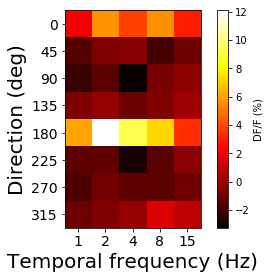

In [4]:
# skip the blank sweep column of the temporal frequency dimension
plt.imshow(dg.response[:,1:,cell_loc,0], cmap='hot', interpolation='none')
plt.xticks(range(5), dg.tfvals[1:])
plt.yticks(range(8), dg.orivals)
plt.xlabel("Temporal frequency (Hz)", fontsize=20)
plt.ylabel("Direction (deg)", fontsize=20)
plt.tick_params(labelsize=14)
cbar= plt.colorbar()
cbar.set_label("DF/F (%)")

The `peak` property of the analysis object is a Pandas DataFrame of peak conditions (direction and temporal frequency) as well as computed response metrics.  For drifting gratings this includes:

    ori_dg: preferred direction (index into dg.orivals)
    tf_dg: preferred temporal frequency (index into tf.tfvals)
    response_reliability_dg: response reliability 
    osi_dg: orientation selectivity index
    dsi_dg: direction selectivity index
    ptest_dg: number of signficant cells
    p_run_dg: K-S statistic comparing running trials to stationary trials
    run_modulation_dg: ratio of mean fluorescence during running vs static
    cv_dg: circular variance 

In [5]:
dg.peak.loc[cell_loc]

C:\Users\sp3660\Anaconda3\lib\site-packages\allensdk\brain_observatory\drifting_gratings.py:191: RuntimeWarning: invalid value encountered in double_scalars
  peak.cv_os_dg.iloc[nc] = np.abs(CV_top_os.sum())/tuning.sum()
C:\Users\sp3660\Anaconda3\lib\site-packages\allensdk\brain_observatory\drifting_gratings.py:192: RuntimeWarning: invalid value encountered in double_scalars
  peak.cv_ds_dg.iloc[nc] = np.abs(CV_top_ds.sum())/tuning.sum()
C:\Users\sp3660\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


ori_dg                         4
tf_dg                          2
reliability_dg          0.186626
osi_dg                   1.20235
dsi_dg                  0.358697
peak_dff_dg              12.0947
ptest_dg             5.27503e-23
p_run_dg               0.0612578
run_modulation_dg      -0.620711
cv_os_dg                       1
cv_ds_dg                0.358697
tf_index_dg              0.30792
cell_specimen_id       517425074
Name: 97, dtype: object

Next let's plot all trials for a given cell's preferred condition.

In [6]:
pref_ori = dg.orivals[dg.peak.ori_dg[cell_loc]]
pref_tf = dg.tfvals[dg.peak.tf_dg[cell_loc]]
print("Preferred direction:", pref_ori)
print("Preferred temporal frequency:", pref_tf)

Preferred direction: 180
Preferred temporal frequency: 2


In [7]:
pref_trials = dg.stim_table[(dg.stim_table.orientation==pref_ori)&(dg.stim_table.temporal_frequency==pref_tf)]
pref_trials

,temporal_frequency,orientation,blank_sweep,start,end
1,2.0,180.0,0.0,837,897
71,2.0,180.0,0.0,7157,7217
73,2.0,180.0,0.0,7338,7398
100,2.0,180.0,0.0,9776,9835
141,2.0,180.0,0.0,13478,13537
175,2.0,180.0,0.0,16549,16609
271,2.0,180.0,0.0,55014,55074
291,2.0,180.0,0.0,56820,56879
323,2.0,180.0,0.0,59709,59769
435,2.0,180.0,0.0,97819,97879


`sweep_response` is a DataFrame that contains the DF/F of each cell during each stimulus trial. It shares its index with `stim_table`. Each cell contains a timeseries that extends from 1 second prior to the start of the trial to 1 second after the end of the trial. The final column of `sweep_response`, named `dx`, is the running speed of the mouse during each trial. The data in this DataFrame is used to create another DataFrame called `mean_sweep_response` that contains the mean DF/F during the trial for each cell (and the mean running speed in the last column).

In [8]:
subset = dg.sweep_response[(dg.stim_table.orientation==pref_ori)&(dg.stim_table.temporal_frequency==pref_tf)]

Here we look at the mean running speed during trials that presented the preferred condition.

In [9]:
subset_mean = dg.mean_sweep_response[(dg.stim_table.orientation==pref_ori)&(dg.stim_table.temporal_frequency==pref_tf)]
subset_mean['dx']

1       0.920868
71      0.060374
73      0.034393
100     4.897258
141    -0.000856
175     0.018537
271    38.012079
291     0.000437
323    36.196411
435    -0.012866
449    11.234307
488     5.972907
509     1.967057
518    -0.004841
606     6.747042
Name: dx, dtype: float64

Plot the response to each trial of the preferred condition, labeled with the mean running speed during the trial

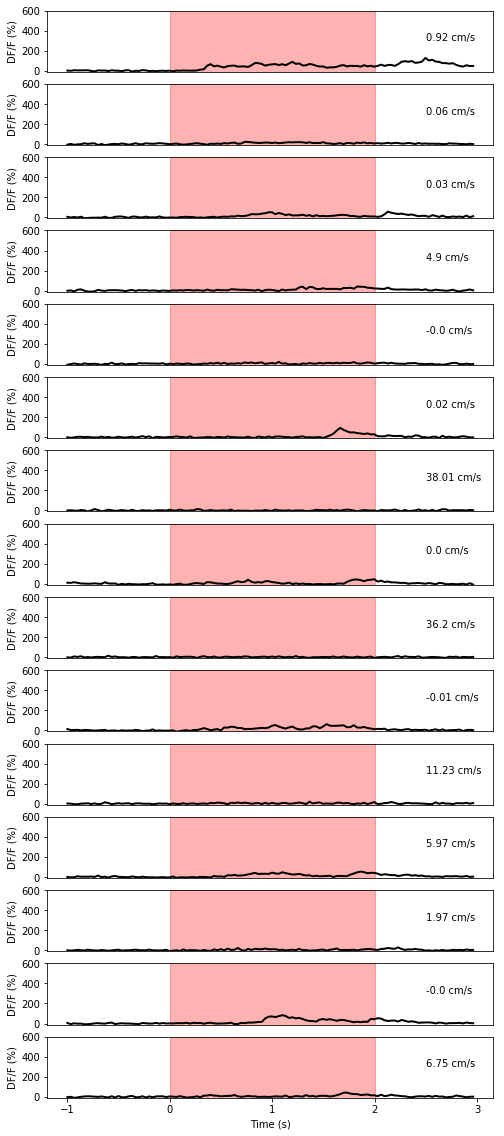

In [10]:
trial_timestamps = np.arange(-1*dg.interlength, dg.interlength+dg.sweeplength, 1.)/dg.acquisition_rate
plt.figure(figsize=(8,20))
for i in range(len(subset)):
    plt.subplot(len(pref_trials),1,i+1)
    plt.plot(trial_timestamps, subset[str(cell_loc)].iloc[i], color='k', lw=2)
    plt.axvspan(0,2,color='red', alpha=0.3)
    plt.ylabel("DF/F (%)")
    plt.ylim(-10,600)
    plt.yticks(range(0,700,200))
    plt.text(2.5, 300, str(round(subset_mean['dx'].iloc[i],2))+" cm/s")
    if i<(len(subset)-1):
        plt.xticks([])
    else:
        plt.xticks([-1,0,1,2,3])
        plt.xlabel("Time (s)")

## Static Gratings
The static gratings analysis object is quite similar to the drifting gratings analysis object.  Here we'll just take a look at the `peak` table, which contains information about the preferred orientation, spatial frequency, phase, as well as a number of other metrics.

In [11]:
from allensdk.brain_observatory.static_gratings import StaticGratings

# example loading drifing grating data
data_set = boc.get_ophys_experiment_data(510938357)

sg = StaticGratings(data_set)

2019-06-28 15:30:54,296 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/516802541


In [ ]:
sg.peak.head()

## Natural Scenes
The natural scenes analysis object is again similar to the others.  In addition to computing the `sweep_response` and `mean_sweep_response` arrays, `NaturalScenes` reports the cell's preferred scene, running modulation, time to peak response, and other metrics.

In [ ]:
from allensdk.brain_observatory.natural_scenes import NaturalScenes

data_set = boc.get_ophys_experiment_data(510938357)

ns = NaturalScenes(data_set)
print("done analyzing natural scenes")

In [ ]:
ns.peak.head()

## Locally Sparse Noise
The locally sparse noise stimulus object is a bit different from the others.  It does not have a peak condition table, instead providing a method to retrieve the "on" and "off" receptive fields of all cells.  The receptive field of a cell is computed by averaging responses to trials in which a given sparse noise grid location is on/off.

In [ ]:
from allensdk.brain_observatory.locally_sparse_noise import LocallySparseNoise
import allensdk.brain_observatory.stimulus_info as stim_info

specimen_id = 587179530
cell = boc.get_cell_specimens(ids=[specimen_id])[0]

exp = boc.get_ophys_experiments(experiment_container_ids=[cell['experiment_container_id']],
                                stimuli=[stim_info.LOCALLY_SPARSE_NOISE])[0]
                                         
data_set = boc.get_ophys_experiment_data(exp['id'])
lsn = LocallySparseNoise(data_set)
print("done analyzing locally sparse noise")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

cell_idx = data_set.get_cell_specimen_indices([specimen_id])[0]

plt.imshow(lsn.receptive_field[:,:,cell_idx,0], interpolation='nearest', cmap='PuRd', origin='lower')
plt.title("on receptive field")
plt.show()
plt.imshow(lsn.receptive_field[:,:,cell_idx,1], interpolation='nearest', cmap='Blues', origin='lower')
plt.title("off receptive field")
plt.show()